<a href="https://colab.research.google.com/github/rubyhung0529/Thesis/blob/main/%E6%B7%A1%E6%B0%B4%E6%B2%B3%E6%B5%81%E5%9F%9F_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm
import torch
pd.options.display.float_format = '{:.4f}'.format#評分分數不要科學記號,到小數點後三位
drive.mount('/content/drive')
np.random.seed(31)
random.seed(31)
torch.manual_seed(31)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
full = pd.read_csv('/content/drive/My Drive/碩士論文資料/淡水河流域_cleaned(full).csv').sort_values(by='採樣日期')
full = pd.DataFrame(full)
print(full.shape)
full.head()

(2239, 24)


,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,2.3000,13.2000,14.1000,8.1000,247.0000,10.0000,97.5000,1.0000,5.5000,54.3000,4200.0000,0.1100,0.0270,0.5400,0.0010,0.0330,0.0060,0.0012,0.0005,0.0050,0.0210,0.1220
921,暖江橋,2005-03-01 01:44:00,1.5000,17.5000,16.4000,6.6000,144.0000,10.8000,109.8000,2.0000,6.6000,42.1000,17000.0000,0.3500,0.0160,0.7600,0.0010,0.0120,0.0060,0.0014,0.0005,0.0050,0.0790,0.0790
1001,三鶯大橋,2005-03-01 02:20:00,2.3000,13.0000,14.9000,8.0000,201.0000,10.0000,99.5000,1.0000,4.8000,58.9000,2200.0000,0.0800,0.0140,0.5200,0.0010,0.0140,0.0040,0.0009,0.0003,0.0050,0.0300,0.1190
924,六合橋,2005-03-01 02:36:00,2.3000,16.5000,15.9000,6.4000,266.0000,10.0000,100.9000,2.3000,11.6000,92.2000,43000.0000,0.3600,0.0190,0.9700,0.0010,0.0170,0.0030,0.0010,0.0013,0.0090,0.0610,0.1390
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,1.0000,12.5000,14.4000,7.5000,113.0000,10.1000,98.9000,1.0000,5.6000,16.6000,2400.0000,0.0800,0.0140,1.1400,0.0010,0.0100,0.0070,0.0013,0.0011,0.0030,0.0290,0.0420


# define X,y

In [3]:
col = full.columns.tolist()
x_col = col[2:12]
y_col = ['大腸桿菌群','氨氮','總磷','砷','錳']
x_col,y_col

(['河川污染指數',
  '氣溫',
  '水溫',
  '酸鹼值',
  '導電度',
  '溶氧(電極法)',
  '溶氧飽和度',
  '生化需氧量',
  '化學需氧量',
  '懸浮固體'],
 ['大腸桿菌群', '氨氮', '總磷', '砷', '錳'])

# scaled

In [4]:
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
full[x_col] = ss_x.fit_transform(full[x_col])
full[y_col] = ss_y.fit_transform(full[y_col])
full.head()

,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,-0.2499,-1.8174,-1.8293,1.3239,-0.2048,1.0956,0.5661,-0.4758,-0.4337,-0.0255,-0.2295,-0.6466,-0.6323,0.5400,0.0010,0.0330,0.0060,-0.0082,0.0005,0.0050,0.0210,0.1103
921,暖江橋,2005-03-01 01:44:00,-0.6494,-1.1234,-1.3416,-2.2729,-0.2246,1.3649,0.9272,-0.2630,-0.3640,-0.0472,-0.2123,-0.5181,-0.6686,0.7600,0.0010,0.0120,0.0060,0.0964,0.0005,0.0050,0.0790,-0.0480
1001,三鶯大橋,2005-03-01 02:20:00,-0.2499,-1.8497,-1.6596,1.0841,-0.2137,1.0956,0.6248,-0.4758,-0.4780,-0.0173,-0.2322,-0.6627,-0.6752,0.5200,0.0010,0.0140,0.0040,-0.1652,0.0003,0.0050,0.0300,0.0992
924,六合橋,2005-03-01 02:36:00,-0.2499,-1.2848,-1.4476,-2.7525,-0.2011,1.0956,0.6659,-0.1992,-0.0473,0.0418,-0.1773,-0.5127,-0.6587,0.9700,0.0010,0.0170,0.0030,-0.1129,0.0013,0.0090,0.0610,0.1729
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,-0.8991,-1.9304,-1.7657,-0.1148,-0.2306,1.1292,0.6072,-0.4758,-0.4273,-0.0925,-0.2319,-0.6627,-0.6752,1.1400,0.0010,0.0100,0.0070,0.0441,0.0011,0.0030,0.0290,-0.1842


# define model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
class Net(nn.Module):
  def __init__(self,x_size,y_size):
    super().__init__()
    
    # hyperparamters
    self.h_size = 20
    self.num_layers = 1
    self.num_directions = 1
    self.seq_len = 3
    
    # nets
    self.rnn = nn.RNN(x_size,self.h_size,self.num_layers)#input_size,hidden_size,num_layers
    self.lr = nn.Linear(self.h_size*self.seq_len,y_size)#input_size,output_size

  def forward(self,x):
    batch_size,seq_size,input_size = x.shape
    h0 = torch.randn(self.num_layers*self.num_directions,batch_size,self.h_size)
    x = x.reshape(seq_size,batch_size,input_size)#seq_len, batch, input_size
    output,h_n = self.rnn(x,h0)
    output = output.reshape(batch_size,-1)
    output = self.lr(output)
    return output

# prepare data and forward test

In [7]:
def create_inout_sequences(input_data,t):
  x = []
  y = []
  for i in range(len(input_data)-t):
    x.append(input_data.iloc[i:i+t][x_col+y_col].values)
    y.append(input_data.iloc[[i+t-1]][y_col].values)
  return np.array(x),np.array(y)

x,y = create_inout_sequences(full,t=3)

# batch_size,seq_size,feature_size
x.shape,y.shape

((2236, 3, 15), (2236, 1, 5))

In [8]:
X = torch.FloatTensor(x)
Y = torch.FloatTensor(y).reshape(-1,len(y_col))
sp = int(len(X)*0.7)
X_train,X_test = X[:sp,:],X[sp:,:]
Y_train,Y_test = Y[:sp,:],Y[sp:,:]
train = torch.utils.data.TensorDataset(X_train,Y_train)
train_iter = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test = torch.utils.data.TensorDataset(X_test,Y_test)
test_iter = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

# train loop

In [9]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        #print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
        #    epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            #print('record net')
    
    return best_net

In [10]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
model = Net(len(x_col+y_col),len(y_col))
params = list(model.parameters())
optimizer = torch.optim.Adam(params,lr=0.01)
loss_fn = nn.MSELoss()
model = train(model,train_iter,test_iter,loss_fn,optimizer,num_epochs=50)


y_pred = model(X_test).detach().cpu().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)

y_real = Y_test.detach().cpu().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)

res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])
for i in y_col:
  res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
  res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
  res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res,res.loc['AVG','MAPE']

(          R2    MSE    MAPE
 大腸桿菌群 0.9567 0.0121 53.2788
 氨氮    0.9902 0.0052 29.0352
 總磷    0.9402 0.0140 98.9354
 砷     0.8827 0.0122 60.1126
 錳     0.7975 0.0071 77.9733
 AVG   0.9134 0.0101 63.8671, 63.86707782745361)

In [12]:
res

,R2,MSE,MAPE
大腸桿菌群,0.9567,0.0121,53.2788
氨氮,0.9902,0.0052,29.0352
總磷,0.9402,0.0140,98.9354
砷,0.8827,0.0122,60.1126
錳,0.7975,0.0071,77.9733
AVG,0.9134,0.0101,63.8671


大腸桿菌群


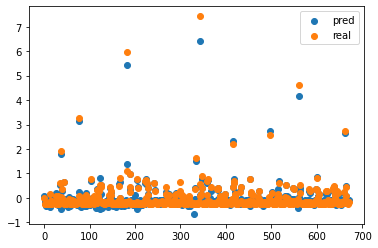

氨氮


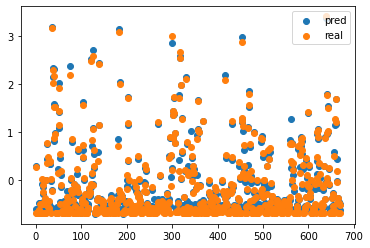

總磷


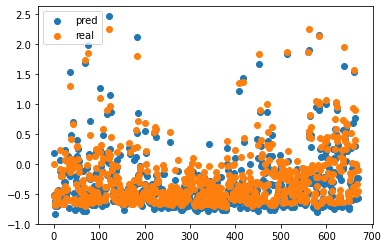

砷


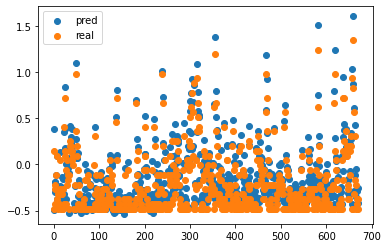

錳


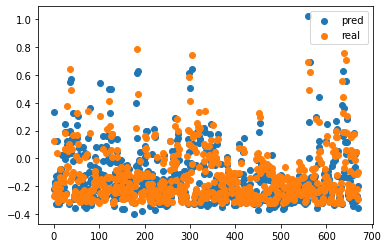

In [13]:
import matplotlib.pyplot as plt
for name in y_pred.columns:
  print(name)
  plt.scatter(y_pred[name].index,y_pred[name],label='pred')
  plt.scatter(y_real[name].index,y_real[name],label='real')
  plt.legend()
  plt.show()